# Building Graph Practice

When building a multi-agent system in LangGraph, it is crucial to first conceptualize the overall graph structure abstractly rather than focusing on immediate implementation. Starting with an abstract graph model allows for easier modifications and adaptations, enabling a more agile approach to refining individual agent behaviors.

Think of the graph as a blueprint—once the relationships and information flow are well-defined, implementing specific agents and their behaviors becomes a more structured and efficient process. By prioritizing conceptual design, you enable the flexibility to experiment with different agent roles and interactions without committing prematurely to rigid implementations. 

This notebook provides a step-by-step guide to building a graph without focusing on implementation details. The goal is to help you understand the key components of a graph and how they interact with each other.

Before you start, make sure you have a clear understanding of the following concepts:
- [LangGraph QuickStart - finish until Part 2](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [LangGraph Basic - How to define and update graph state](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/)
- [LangGraph Basic - How to create a sequence of steps](https://langchain-ai.github.io/langgraph/how-tos/sequence/)

<br>

## 1. State Definitions
---

In [9]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator


class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]


class PDFState(TypedDict):
    filepath: str  # path
    filetype: str  # pdf
    page_numbers: list[int]  # page numbers
    batch_size: int  # batch size
    split_filepaths: list[str]  # split files
    analyzed_files: list[str]  # analyzed files
    page_elements: dict[int, dict[str, list[dict]]]  # page elements
    page_metadata: dict[int, dict]  # page metadata
    page_summary: dict[int, str]  # page summary
    images: list[str]  # image paths
    image_summary: list[str]  # image summary
    tables: list[str]  # table
    table_summary: dict[int, str]  # table summary
    table_markdown: dict[int, str]  # table markdown
    texts: list[str]  # text
    text_summary: dict[int, str]  # text summary
    table_summary_data_batches: list[dict]  # table summary data batches

<br>

## 2. Node Definition
---

### Node Definition for PDF retrieval

In [10]:
def split_pdf(state: PDFState) -> PDFState:
    split_files = ""
    return PDFState(split_filepaths=split_files)


def layout_analysis(state: PDFState) -> PDFState:
    page_elements = ""
    return PDFState(page_elements=page_elements)


def page_extract(state: PDFState) -> PDFState:
    page_texts = ""
    return PDFState(texts=page_texts)


def image_extract(state: PDFState) -> PDFState:
    images = ""
    return PDFState(images=images)


def table_extract(state: PDFState) -> PDFState:
    tables = ""
    return PDFState(tables=tables)


def image_summarize(state: PDFState) -> PDFState:
    image_summary = ""
    return PDFState(image_summary=image_summary)


def table_summarize(state: PDFState) -> PDFState:
    table_summary = ""
    return PDFState(table_summary=table_summary)


def extract_page_text(state: PDFState) -> PDFState:
    page_texts = ""
    return PDFState(texts=page_texts)


def page_summarize(state: PDFState) -> PDFState:
    text_summary = ""
    return PDFState(text_summary=text_summary)


def markdownify_table(state: PDFState) -> PDFState:
    table_markdown = ""
    return PDFState(table_markdown=table_markdown)

### Make a subgraph and Visualize it

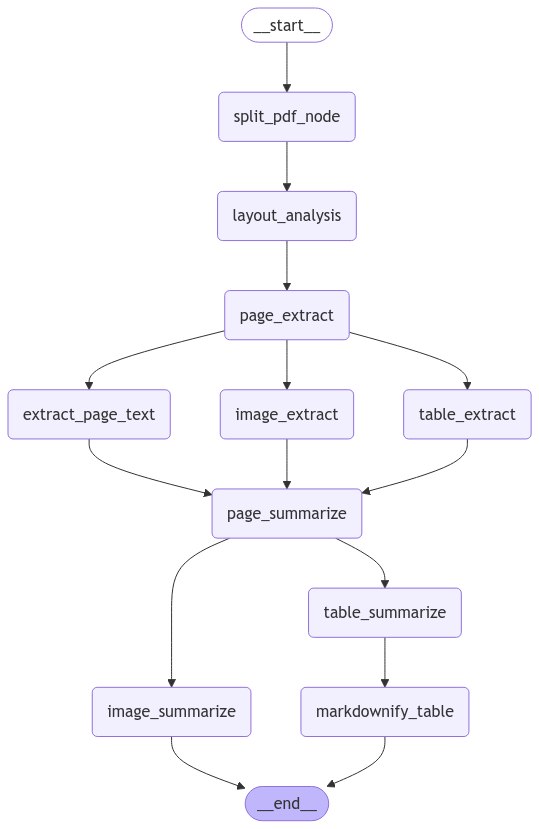

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from azure_genai_utils.graphs import visualize_langgraph

workflow = StateGraph(PDFState)

# Node definition
workflow.add_node("split_pdf_node", split_pdf)
workflow.add_node("layout_analysis", layout_analysis)
workflow.add_node("page_extract", page_extract)
workflow.add_node("image_extract", image_extract)
workflow.add_node("table_extract", table_extract)
workflow.add_node("extract_page_text", extract_page_text)
workflow.add_node("page_summarize", page_summarize)
workflow.add_node("image_summarize", image_summarize)
workflow.add_node("table_summarize", table_summarize)
workflow.add_node("markdownify_table", markdownify_table)

# Edge connection
workflow.add_edge("split_pdf_node", "layout_analysis")
workflow.add_edge("layout_analysis", "page_extract")
workflow.add_edge("page_extract", "image_extract")
workflow.add_edge("page_extract", "table_extract")
workflow.add_edge("page_extract", "extract_page_text")
workflow.add_edge("image_extract", "page_summarize")
workflow.add_edge("table_extract", "page_summarize")
workflow.add_edge("extract_page_text", "page_summarize")
workflow.add_edge("page_summarize", "image_summarize")
workflow.add_edge("page_summarize", "table_summarize")
workflow.add_edge("image_summarize", END)
workflow.add_edge("table_summarize", "markdownify_table")
workflow.add_edge("markdownify_table", END)

workflow.set_entry_point("split_pdf_node")

memory = MemorySaver()
subgraph = workflow.compile(checkpointer=memory)
visualize_langgraph(subgraph)

### Node Definition for whole workflow

In [12]:
def retrieve(state: GraphState) -> GraphState:
    documents = ""
    return {"context": documents}


def grade_documents(state: GraphState) -> GraphState:
    binary_score = "yes"
    return {"binary_score": binary_score}


def rewrite_query(state: GraphState) -> GraphState:
    documents = ""
    return GraphState(context=documents)


def generate(state: GraphState) -> GraphState:
    answer = "answer from LLM"
    return GraphState(answer=answer)


def relevance_check(state: GraphState) -> GraphState:
    binary_score = "yes"
    return GraphState(binary_score=binary_score)


def web_search(state: GraphState) -> GraphState:
    documents = state["context"] = "context"
    searched_documents = ""
    documents += searched_documents
    return GraphState(context=documents)


def handle_error(state: GraphState) -> GraphState:
    error = ""
    return GraphState(context=error)


def decide_to_generate(state: GraphState) -> GraphState:
    if state["binary_score"] == "yes":
        return "END"
    else:
        return "retry"


def check_relevance(state: GraphState) -> GraphState:
    binary_score = "yes"
    return GraphState(binary_score=binary_score)

### Make a graph and Visualize it

You can see the whole workflow in the graph above. <br>
If you want to replace the PDF retrieval node with the subgraph, you can add the subgraph node to the workflow.

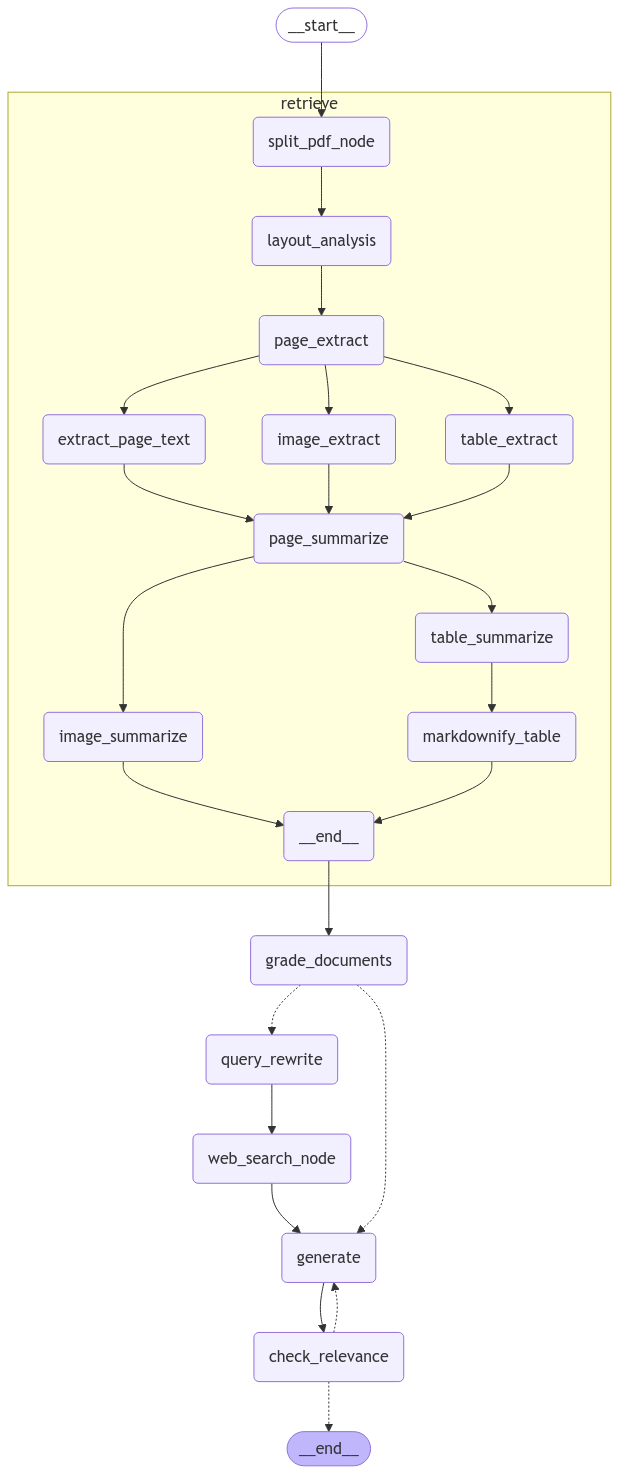

In [13]:
from langgraph.graph import END, StateGraph, START

REPLACE_PDF_RETRIEVAL_SUBGRAPH = True

workflow = StateGraph(GraphState)

# Node definition
if REPLACE_PDF_RETRIEVAL_SUBGRAPH:
    workflow.add_node("retrieve", subgraph)
else:
    workflow.add_node("retrieve", retrieve)

workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", rewrite_query)
workflow.add_node("web_search_node", web_search)
workflow.add_node("check_relevance", check_relevance)

# Edge connection
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    decide_to_generate,
    {
        "generate": "generate",
        END: END,
    },
)

app = workflow.compile()
visualize_langgraph(app, xray=True)